Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

Введение: прогнозирование числа смертей в результате несчастного случая в США с 1978 по 1980 гг. согласно предоставленному датасету.

In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import pmdarima


In [71]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])

Производим первичный осмотр данных

In [72]:
df

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017
...,...
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070


In [73]:
df.shape

(72, 1)

In [74]:
df.head()

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017


In [75]:
df.info() # нулевых значений нет - хорошо

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1973-01-01 to 1978-12-01
Data columns (total 1 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   Accidental deaths in USA: monthly, 1973 ? 1978  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


In [76]:
df.describe() # некоторый стат. анализ

,"Accidental deaths in USA: monthly, 1973 ? 1978"
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


In [77]:
df.tail() # имеющиеся данные заканчиваются на декабре 1978 г.

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070
1978-11-01,8633
1978-12-01,9240


Производим сглаживание исходного ряда для выявления трендов

In [78]:
def plotMovingAverage(series, n):

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

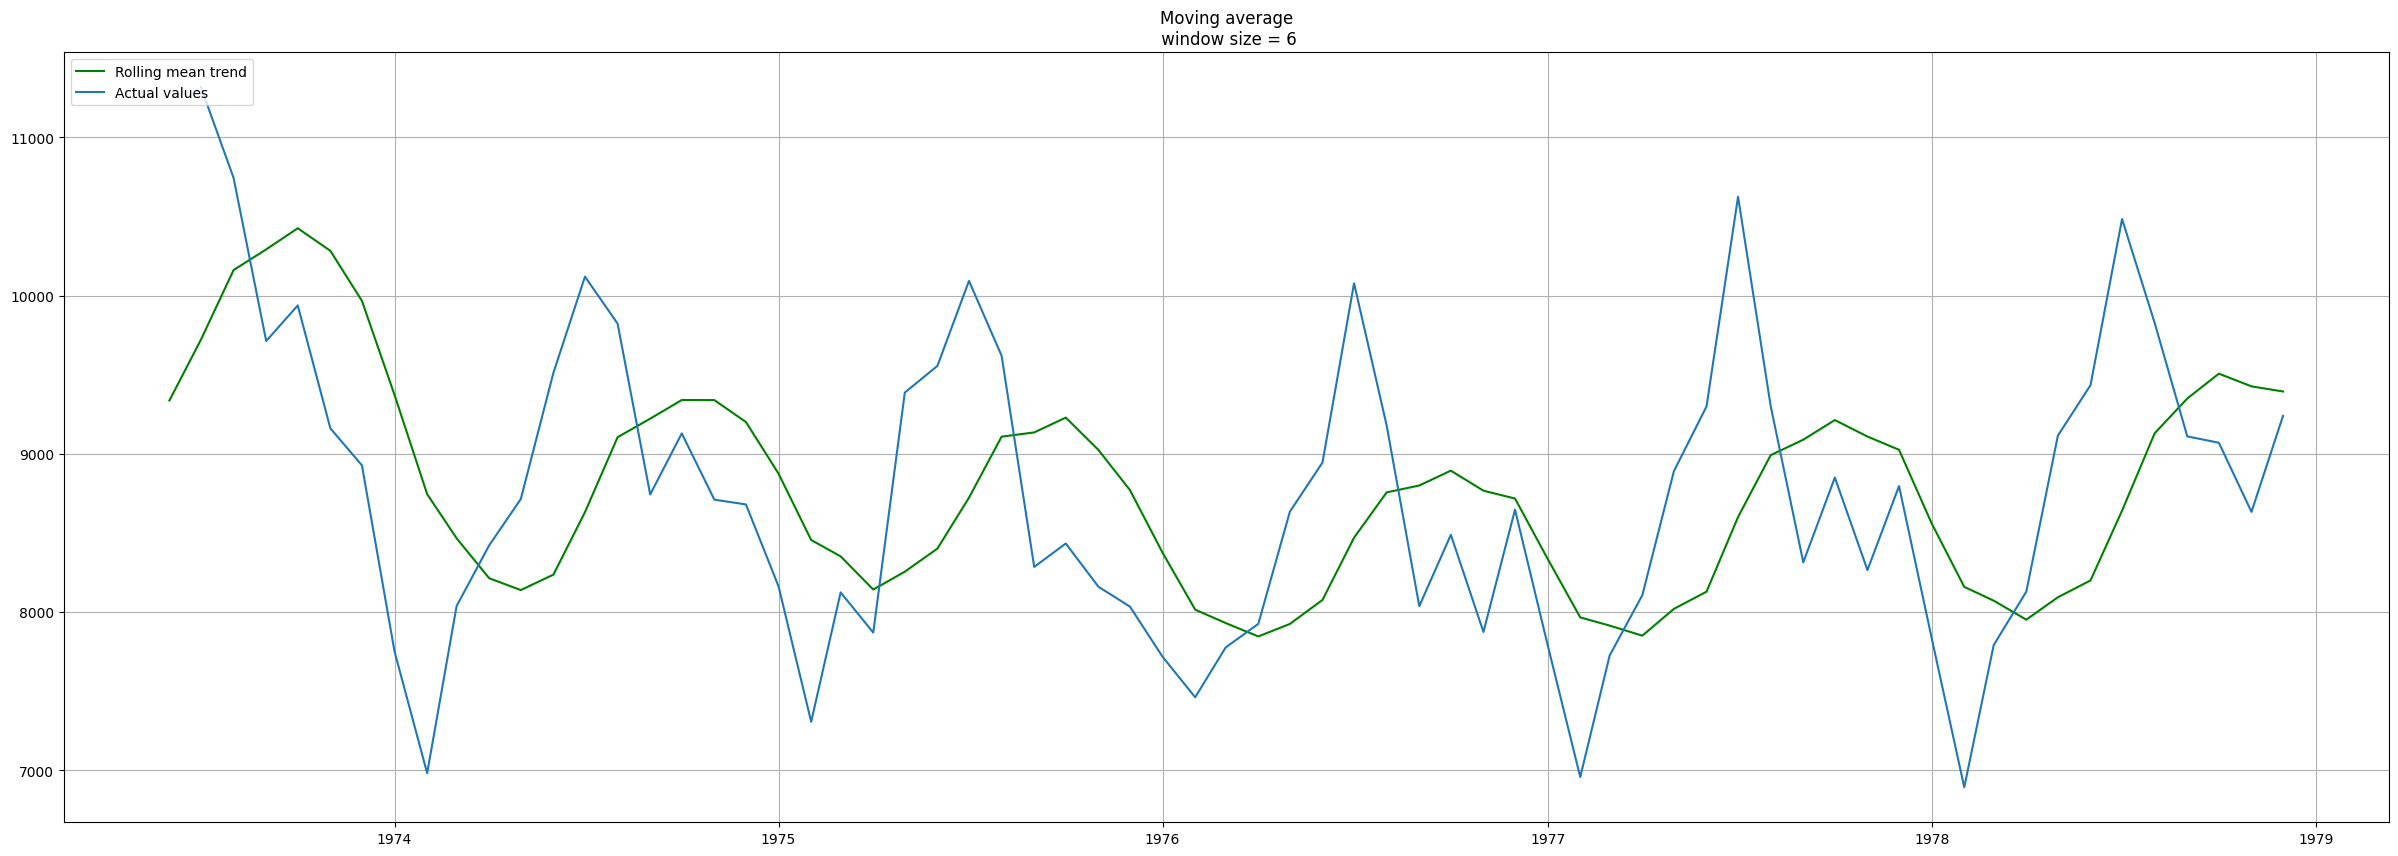

In [79]:
plotMovingAverage(df, 6)

Проверяем ряд на стационарность

In [80]:
df2 = df.copy()

In [81]:
def plotProcess(n_samples=72, rho=0):
    x = w = df2.iloc[:, 0].values
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        print(sm.tsa.stattools.adfuller(x))

(-2.555798409635678, 0.10248122056865133, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 870.8496020346796)
(-4.544217283054495, 0.0001634622865164257, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 878.5315633906168)
(-0.936969908921668, 0.77555409168461, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 899.095816661741)
(3.317724379807485, 1.0, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 892.8204381655862)


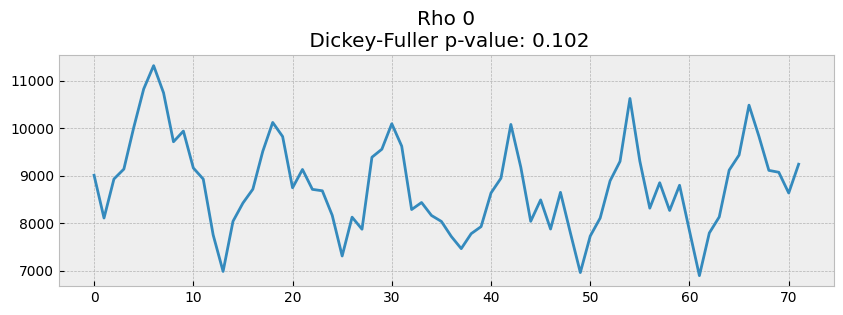

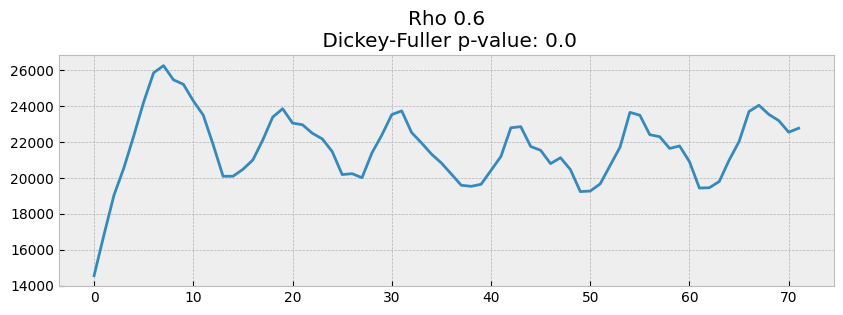

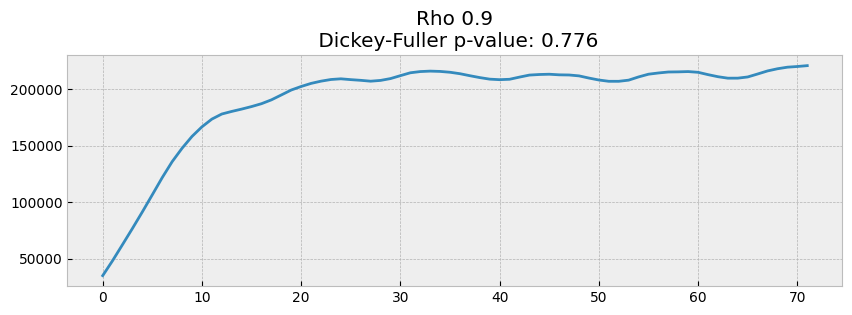

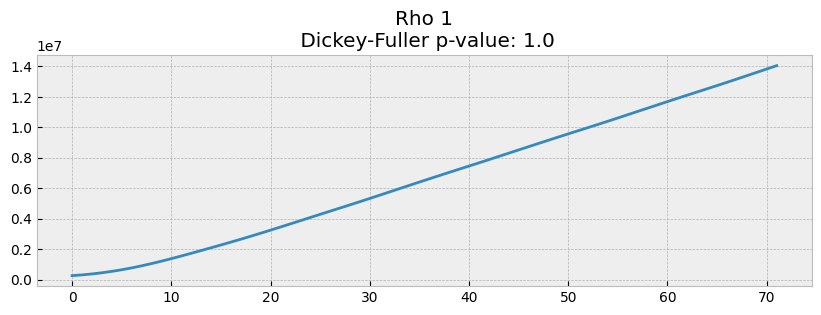

In [82]:
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получилась такая же картина, как и на построенном выше (при сглаживании), т.е. ряд стационарен. На втором значение р увеличилось до 0.6, и наш ряд все еще стационарен (так как критерий Dickey-Fuller равен 0). Третий график всё сильнее отклоняется от нулевого среднего значения (при р = 0.9), а на четвертом (р = 1) однозначно ряд не стационарен.


Проверив ряд на стационарность, можно строить прогноз. Для этого сперва разделим нашу выборку на обучающую и тестовую

In [91]:
X_train = df[:60]
X_test = df[60:]

Подбираем параметры для модели

In [93]:
model = pmdarima.arima.auto_arima(X_train, seasonal=True, m=12)

In [94]:
model.fit(X_train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [95]:
pred = model.predict(n_periods=12)

In [96]:
pred

1978-01-01     8063.431152
1978-02-01     7375.526277
1978-03-01     8056.171917
1978-04-01     8290.203228
1978-05-01     9118.124962
1978-06-01     9516.200939
1978-07-01    10603.962975
1978-08-01     9602.179451
1978-09-01     8525.166586
1978-10-01     8963.782808
1978-11-01     8415.313117
1978-12-01     8842.215987
Freq: MS, dtype: float64

В качестве метрики оценки качества модели используем среднеквадратичную ошибку

In [97]:
mean_squared_error(X_test,pred)**0.5

290.4679102977164

Посмотрим отличие предсказанных значений от тестовой выборки

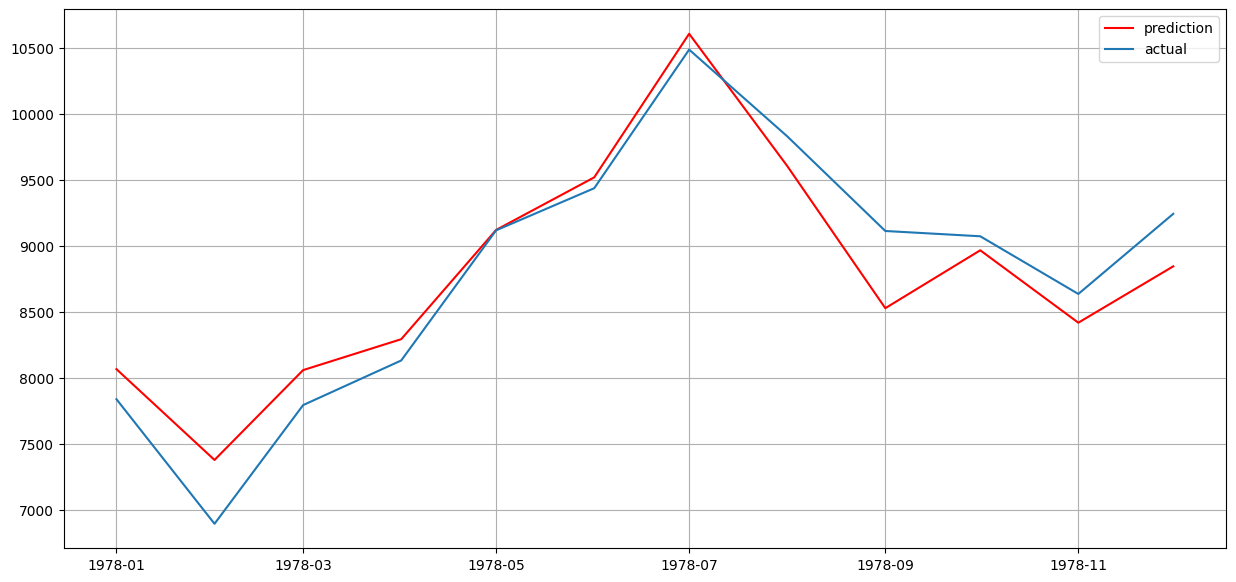

In [98]:
plt.figure(figsize=(15, 7))
plt.plot(pred, "r", label="prediction")
plt.plot(X_test, label="actual")
plt.legend(loc="best")
plt.grid(True);

Обучаем модель на всех имеющихся данных, чтобы сделать прогноз

In [112]:
sarima_model = sm.tsa.statespace.SARIMAX(df, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [113]:
forecast = sarima_model.forecast(steps = 24)

In [114]:
forecast

1979-01-01     8132.066749
1979-02-01     7174.705703
1979-03-01     7898.957597
1979-04-01     8089.906527
1979-05-01     8947.408628
1979-06-01     9386.696103
1979-07-01    10260.681611
1979-08-01     9565.237422
1979-09-01     8572.285080
1979-10-01     8823.335015
1979-11-01     8330.840669
1979-12-01     8671.281557
1980-01-01     7962.013551
1980-02-01     7133.205346
1980-03-01     7885.588246
1980-04-01     8077.955060
1980-05-01     8928.499914
1980-06-01     9381.178920
1980-07-01    10238.925318
1980-08-01     9540.015950
1980-09-01     8520.675174
1980-10-01     8799.664676
1980-11-01     8301.857329
1980-12-01     8616.737120
Freq: MS, Name: predicted_mean, dtype: float64

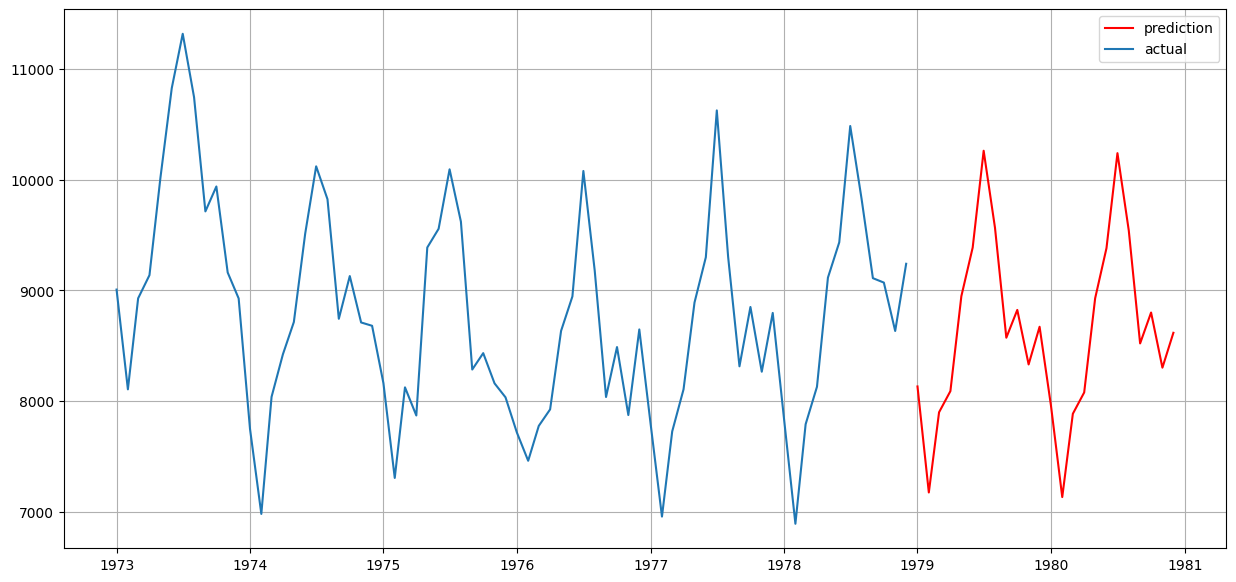

In [115]:
plt.figure(figsize=(15, 7))
plt.plot(forecast, "r", label="prediction")
plt.plot(df, label="actual")
plt.legend(loc="best")
plt.grid(True);

Выводы: в результате была обучена модель SARIMA, построен прогноз числа смертей в результате несчастного случая в США с 1978 по 1980 гг. В качестве метрики оценки точности модели была использована среднеквадратичная ошибка, равная 290.47.